In [72]:
import numpy as np
import pandas as pd
import matplotlib.pyplot as plt
from matplotlib.pylab import rcParams
import seaborn as sns

from sklearn.preprocessing import MinMaxScaler, OneHotEncoder
from xgboost import XGBRegressor, plot_tree
from sklearn.metrics import root_mean_squared_error
from sklearn.model_selection import KFold, train_test_split


In [73]:
ross_df = pd.read_csv('data/rossman/train.csv')
store_df = pd.read_csv('data/rossman/store.csv')
test_df = pd.read_csv('data/rossman/test.csv')
submission_df = pd.read_csv('data/rossman/sample_submission.csv')

C:\Users\Kshitiz\AppData\Local\Temp\ipykernel_17448\4263273381.py:1: DtypeWarning: Columns (7) have mixed types. Specify dtype option on import or set low_memory=False.
  ross_df = pd.read_csv('data/rossman/train.csv')


In [74]:
merged_df = ross_df.merge(store_df, how='left', on = 'Store')
merged_test_df = test_df.merge(store_df, how = 'left', on='Store')

In [75]:
#EDA skip, doing preprocessing and Feature engineering
merged_df.info()

<class 'pandas.core.frame.DataFrame'>
RangeIndex: 1017209 entries, 0 to 1017208
Data columns (total 18 columns):
 #   Column                     Non-Null Count    Dtype  
---  ------                     --------------    -----  
 0   Store                      1017209 non-null  int64  
 1   DayOfWeek                  1017209 non-null  int64  
 2   Date                       1017209 non-null  object 
 3   Sales                      1017209 non-null  int64  
 4   Customers                  1017209 non-null  int64  
 5   Open                       1017209 non-null  int64  
 6   Promo                      1017209 non-null  int64  
 7   StateHoliday               1017209 non-null  object 
 8   SchoolHoliday              1017209 non-null  int64  
 9   StoreType                  1017209 non-null  object 
 10  Assortment                 1017209 non-null  object 
 11  CompetitionDistance        1014567 non-null  float64
 12  CompetitionOpenSinceMonth  693861 non-null   float64
 13  CompetitionO

In [76]:
def split_date(df):
  df['Date'] = pd.to_datetime(df['Date'])
  df['Year'] = df.Date.dt.year
  df['Month'] = df.Date.dt.month
  df['Day'] = df.Date.dt.day
  df['Week'] = df.Date.dt.isocalendar().week

In [77]:
split_date(merged_df)
split_date(merged_test_df)

In [78]:
merged_df

,Store,DayOfWeek,Date,Sales,Customers,Open,Promo,StateHoliday,SchoolHoliday,StoreType,...,CompetitionOpenSinceMonth,CompetitionOpenSinceYear,Promo2,Promo2SinceWeek,Promo2SinceYear,PromoInterval,Year,Month,Day,Week
0,1,5,2015-07-31,5263,555,1,1,0,1,c,...,9.0,2008.0,0,NaN,NaN,NaN,2015,7,31,31
1,2,5,2015-07-31,6064,625,1,1,0,1,a,...,11.0,2007.0,1,13.0,2010.0,"Jan,Apr,Jul,Oct",2015,7,31,31
2,3,5,2015-07-31,8314,821,1,1,0,1,a,...,12.0,2006.0,1,14.0,2011.0,"Jan,Apr,Jul,Oct",2015,7,31,31
3,4,5,2015-07-31,13995,1498,1,1,0,1,c,...,9.0,2009.0,0,NaN,NaN,NaN,2015,7,31,31
4,5,5,2015-07-31,4822,559,1,1,0,1,a,...,4.0,2015.0,0,NaN,NaN,NaN,2015,7,31,31
...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...
1017204,1111,2,2013-01-01,0,0,0,0,a,1,a,...,6.0,2014.0,1,31.0,2013.0,"Jan,Apr,Jul,Oct",2013,1,1,1
1017205,1112,2,2013-01-01,0,0,0,0,a,1,c,...,4.0,2006.0,0,NaN,NaN,NaN,2013,1,1,1
1017206,1113,2,2013-01-01,0,0,0,0,a,1,a,...,NaN,NaN,0,NaN,NaN,NaN,2013,1,1,1
1017207,1114,2,2013-01-01,0,0,0,0,a,1,a,...,NaN,NaN,0,NaN,NaN,NaN,2013,1,1,1


In [79]:
#Model works if store is open else sales = 0 when store closed
merged_df = merged_df[merged_df.Open == 1].copy()

In [80]:
def comp_months(df):
  df['CompetitionOpen'] = 12*(df.Year - df.CompetitionOpenSinceYear) + (df.Month - df.CompetitionOpenSinceMonth)
  df['CompetitionOpen'] = df['CompetitionOpen'].map(lambda x: 0 if x<0 else x).fillna(0)

In [81]:
comp_months(merged_df)
comp_months(merged_test_df)

In [82]:
merged_df.columns

Index(['Store', 'DayOfWeek', 'Date', 'Sales', 'Customers', 'Open', 'Promo',
       'StateHoliday', 'SchoolHoliday', 'StoreType', 'Assortment',
       'CompetitionDistance', 'CompetitionOpenSinceMonth',
       'CompetitionOpenSinceYear', 'Promo2', 'Promo2SinceWeek',
       'Promo2SinceYear', 'PromoInterval', 'Year', 'Month', 'Day', 'Week',
       'CompetitionOpen'],
      dtype='object')

In [83]:
def check_promo_month(row):
  month2str = {1:'Jan', 2:'Feb',3 : 'Mar', 4:'Apr',5:'May',6 : 'Jun', 7: 'Jul', 8: 'Aug', 9: 'Sep', 10 : 'Oct', 11 : 'Nov', 12 : 'Dec'}

  try:
    months = (row['PromoInterval'] or '').split(',')
    if row['Promo2Open'] and month2str[row['Month']] in months:
      return 1
    else:
      return 0
  except Exception:
    return 0
  
def promo_cols(df):
  df['Promo2Open'] = 12 * (df.Year - df.Promo2SinceYear) +  (df.Week - df.Promo2SinceWeek)*7/30.5
  df['Promo2Open'] = df['Promo2Open'].map(lambda x: 0 if x < 0 else x).fillna(0) * df['Promo2']
  df['IsPromo2Month'] = df.apply(check_promo_month, axis=1) * df['Promo2']


In [84]:
promo_cols(merged_df)
promo_cols(merged_test_df)

In [85]:
input_cols = ['Store', 'DayOfWeek', 'Promo', 'StateHoliday', 'SchoolHoliday', 
              'StoreType', 'Assortment', 'CompetitionDistance', 'CompetitionOpen', 
              'Day', 'Month', 'Year', 'Week',  'Promo2', 
              'Promo2Open', 'IsPromo2Month']
target_col = 'Sales'

In [86]:
inputs = merged_df[input_cols].copy()
targets= merged_df[target_col].copy()

In [87]:
test_inputs = merged_test_df[input_cols].copy()

In [88]:
numeric_cols = ['Store', 'Promo', 'SchoolHoliday', 
              'CompetitionDistance', 'CompetitionOpen', 'Promo2', 'Promo2Open', 'IsPromo2Month',
              'Day', 'Month', 'Year', 'Week',  ]
categorical_cols = ['DayOfWeek', 'StateHoliday', 'StoreType', 'Assortment']

In [89]:
inputs[numeric_cols].isna().sum()

Store                     0
Promo                     0
SchoolHoliday             0
CompetitionDistance    2186
CompetitionOpen           0
Promo2                    0
Promo2Open                0
IsPromo2Month             0
Day                       0
Month                     0
Year                      0
Week                      0
dtype: int64

In [90]:
test_inputs[numeric_cols].isna().sum()

Store                   0
Promo                   0
SchoolHoliday           0
CompetitionDistance    96
CompetitionOpen         0
Promo2                  0
Promo2Open              0
IsPromo2Month           0
Day                     0
Month                   0
Year                    0
Week                    0
dtype: int64

In [91]:
#Here prolly null values cuz no competing store is nearby so we want to put a high value instead of a low value through our imputer

max_distance = inputs.CompetitionDistance.max()
max_distance

75860.0

In [92]:
inputs['CompetitionDistance'].fillna(max_distance, inplace=True)
test_inputs['CompetitionDistance'].fillna(max_distance, inplace=True)

C:\Users\Kshitiz\AppData\Local\Temp\ipykernel_17448\751725973.py:1: FutureWarning: A value is trying to be set on a copy of a DataFrame or Series through chained assignment using an inplace method.
The behavior will change in pandas 3.0. This inplace method will never work because the intermediate object on which we are setting values always behaves as a copy.

For example, when doing 'df[col].method(value, inplace=True)', try using 'df.method({col: value}, inplace=True)' or df[col] = df[col].method(value) instead, to perform the operation inplace on the original object.


  inputs['CompetitionDistance'].fillna(max_distance, inplace=True)
C:\Users\Kshitiz\AppData\Local\Temp\ipykernel_17448\751725973.py:2: FutureWarning: A value is trying to be set on a copy of a DataFrame or Series through chained assignment using an inplace method.
The behavior will change in pandas 3.0. This inplace method will never work because the intermediate object on which we are setting values always behaves a

In [93]:
scaler = MinMaxScaler().fit(inputs[numeric_cols])

inputs[numeric_cols] = scaler.transform(inputs[numeric_cols])
test_inputs[numeric_cols] = scaler.transform(test_inputs[numeric_cols])

In [94]:
inputs[categorical_cols] = inputs[categorical_cols].astype(str)
test_inputs[categorical_cols] = test_inputs[categorical_cols].astype(str)

encoder = OneHotEncoder(sparse_output=False, handle_unknown='ignore').fit(inputs[categorical_cols])
encoded_cols = list(encoder.get_feature_names_out(categorical_cols))

inputs[encoded_cols] = encoder.transform(inputs[categorical_cols])
test_inputs[encoded_cols] = encoder.transform(test_inputs[categorical_cols])

In [95]:
X = inputs[numeric_cols + encoded_cols]
X_test = test_inputs[numeric_cols + encoded_cols]

In [96]:
model = XGBRegressor(random_state= 67, n_jobs = -1, max_depth = 4, n_estimators = 20)

In [97]:
model.fit(X,targets)

,objective,'reg:squarederror'
,base_score,None
,booster,None
,callbacks,None
,colsample_bylevel,None
,colsample_bynode,None
,colsample_bytree,None
,device,None
,early_stopping_rounds,None
,enable_categorical,False
,eval_metric,None


In [98]:
preds = model.predict(X)
preds

array([ 7960.0273,  7581.6953,  7993.1504, ...,  7102.0664,  8724.751 ,
       10748.863 ], shape=(844392,), dtype=float32)

In [99]:
def rmse(a,b):
  return root_mean_squared_error(a,b)

In [100]:
rmse(preds,targets)

2397.194091796875

In [101]:
rcParams['figure.figsize'] = 30,30

ImportError: You must install graphviz to plot tree

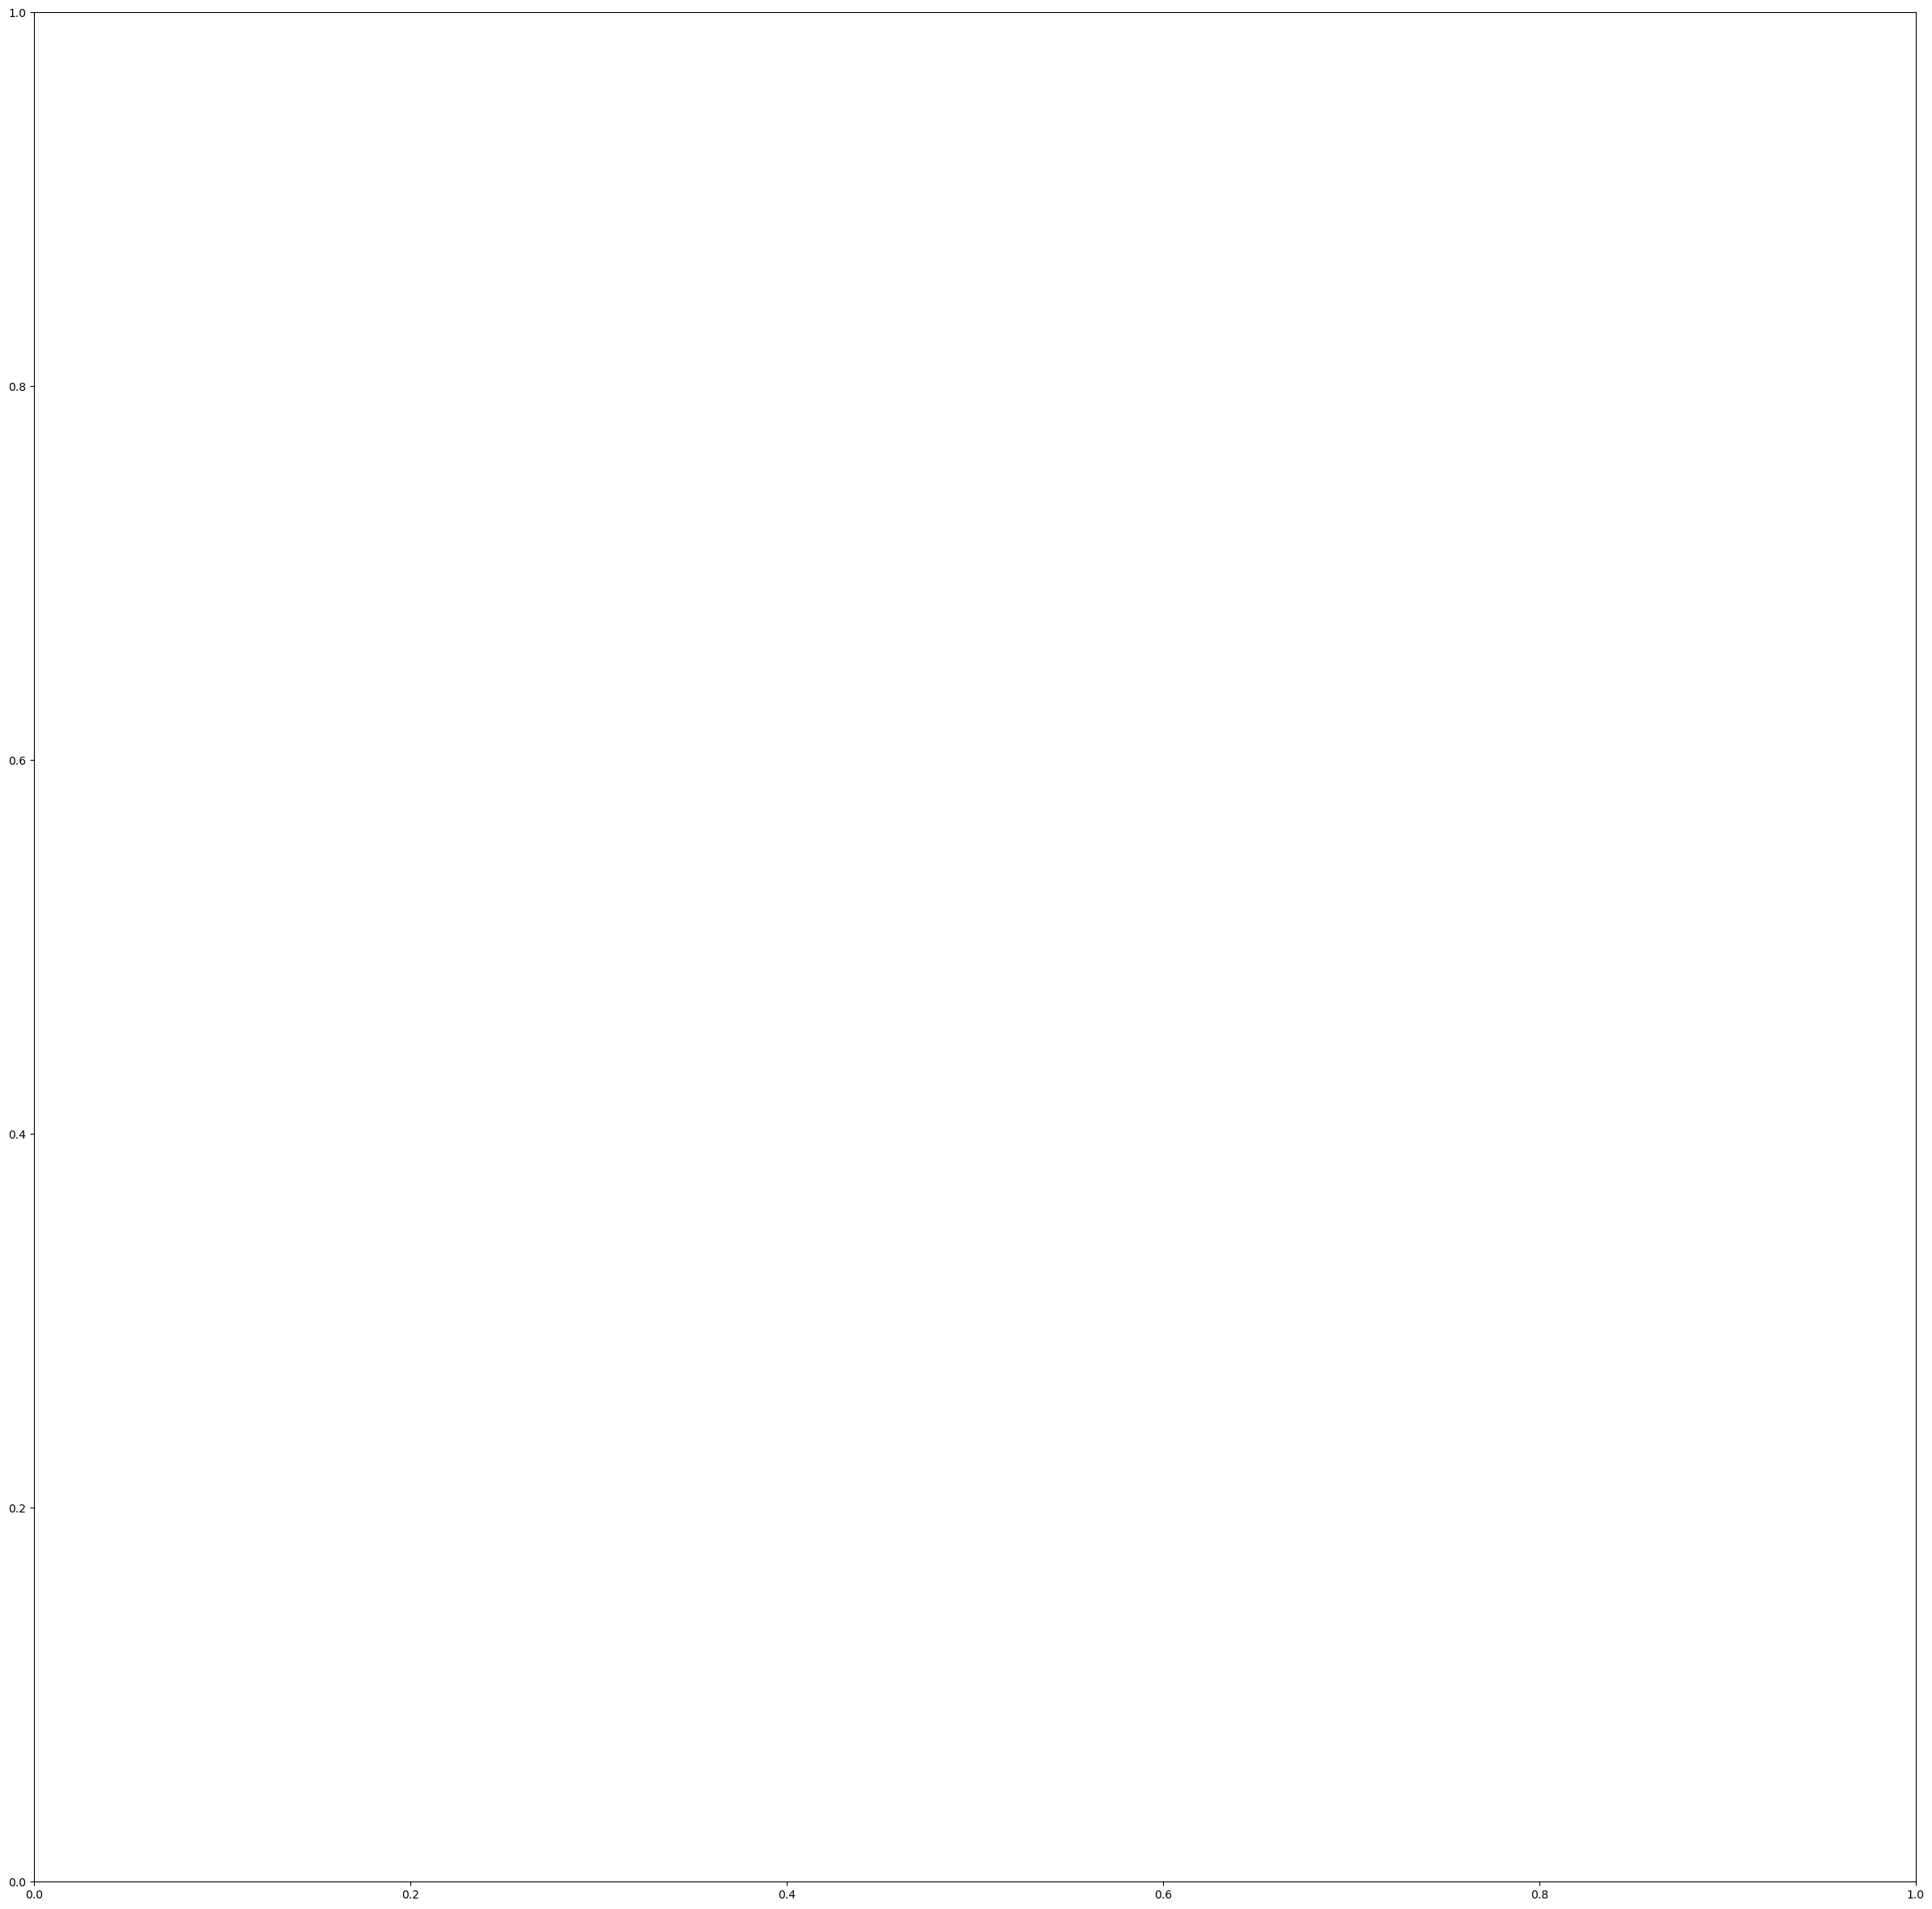

In [102]:
plot_tree(model,rankdir='LR',num_trees= 0)

In [103]:
#Feature Importance

importance_df= pd.DataFrame({
  'feature' : X.columns,
  'importance' : model.feature_importances_ 
}). sort_values('importance', ascending= False)

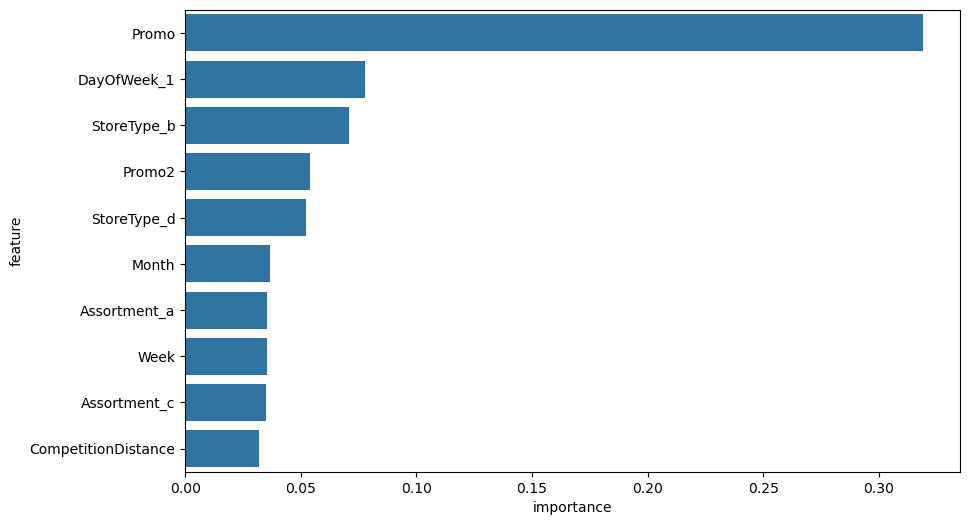

In [104]:
plt.figure(figsize= (10,6))
sns.barplot(data= importance_df.head(10), x= 'importance', y = 'feature')
plt.show()

In [105]:
#K-fold cross validation

def train_and_evaluate(X_train, train_targets, X_val, val_targets, **params):
  model = XGBRegressor(random_state=42, n_jobs=-1, **params)
  model.fit(X_train, train_targets)
  train_rmse = rmse(model.predict(X_train), train_targets)
  val_rmse = rmse(model.predict(X_val), val_targets)
  return model, train_rmse, val_rmse

In [106]:
kfold = KFold(n_splits=5)

In [107]:
models = []

for train_idxs, val_idxs in kfold.split(X):
    X_train, train_targets = X.iloc[train_idxs], targets.iloc[train_idxs]
    X_val, val_targets = X.iloc[val_idxs], targets.iloc[val_idxs]
    model, train_rmse, val_rmse = train_and_evaluate(X_train, 
                                                     train_targets, 
                                                     X_val, 
                                                     val_targets, 
                                                     max_depth=4, 
                                                     n_estimators=20)
    models.append(model)
    print('Train RMSE: {}, Validation RMSE: {}'.format(train_rmse, val_rmse))

Train RMSE: 2386.259033203125, Validation RMSE: 2456.094970703125
Train RMSE: 2401.172119140625, Validation RMSE: 2449.9990234375
Train RMSE: 2411.892578125, Validation RMSE: 2391.591064453125
Train RMSE: 2347.00244140625, Validation RMSE: 2439.332763671875
Train RMSE: 2397.84619140625, Validation RMSE: 2466.51220703125


In [108]:
def predict_avg(models, inputs):
  return np.mean([model.predict(inputs) for model in models], axis=0)

In [109]:
preds = predict_avg(models, X)
preds

array([8108.22  , 7676.0312, 8897.35  , ..., 7368.704 , 7850.032 ,
       9768.516 ], shape=(844392,), dtype=float32)

In [110]:
#Hyperparameter tuning and Regularization

def test_params_kfold(n_splits, **params):
  train_rmses, val_rmses, models = [], [], []
  kfold = KFold(n_splits)
  for train_idxs, val_idxs in kfold.split(X):
    X_train, train_targets = X.iloc[train_idxs], targets.iloc[train_idxs]
    X_val, val_targets = X.iloc[val_idxs], targets.iloc[val_idxs]
    model, train_rmse, val_rmse = train_and_evaluate(X_train, train_targets, X_val, val_targets, **params)
    models.append(model)
    train_rmses.append(train_rmse)
    val_rmses.append(val_rmse)
  print('Train RMSE: {}, Validation RMSE: {}'.format(np.mean(train_rmses), np.mean(val_rmses)))
  return models

In [111]:
X_train, X_val, train_targets,val_targets = train_test_split(X, targets, test_size= 0.1)

In [112]:
def test_params(**params):
  model = XGBRegressor(n_jobs = -1, random_state = 67, **params)
  model.fit(X_train,train_targets)
  train_rmse= rmse(model.predict(X_train), train_targets)
  val_rmse = rmse(model.predict(X_val), val_targets)
  print('Train RMSE: {}, Validation RMSE: {}'.format(train_rmse,val_rmse))

In [113]:
#n_estimators = number of decision tree for the model

test_params(n_estimators = 10)

Train RMSE: 2319.02197265625, Validation RMSE: 2321.378662109375


In [114]:
test_params(n_estimators = 30)

Train RMSE: 1836.9921875, Validation RMSE: 1840.47412109375


In [115]:
test_params(n_estimators = 100)

Train RMSE: 1165.8948974609375, Validation RMSE: 1175.105712890625


In [116]:
test_params(n_estimators = 240)

Train RMSE: 900.6219482421875, Validation RMSE: 917.687744140625


In [117]:
test_params(n_estimators = 500)

Train RMSE: 766.53076171875, Validation RMSE: 796.2637329101562


In [118]:
#max_depth = depth of the tree 

test_params(max_depth = 5, n_estimators = 50)

Train RMSE: 1786.529052734375, Validation RMSE: 1792.3521728515625


In [119]:
test_params(max_depth = 10, n_estimators = 50)

Train RMSE: 815.1956176757812, Validation RMSE: 877.6559448242188


In [120]:
#Learning rate = the alpha for the decision  tree

test_params(n_estimators = 50, learning_rate = 0.01)

Train RMSE: 2788.37060546875, Validation RMSE: 2794.68017578125


In [121]:
test_params(n_estimators = 50, learning_rate = 0.1)

Train RMSE: 2174.893310546875, Validation RMSE: 2180.83642578125


In [122]:
test_params(n_estimators = 50, learning_rate = 0.5)

Train RMSE: 1243.99169921875, Validation RMSE: 1250.3011474609375


In [123]:
test_params(n_estimators = 50, learning_rate = 0.9)

Train RMSE: 1137.3203125, Validation RMSE: 1152.0628662109375


In [124]:
test_params(n_estimators = 50, learning_rate = 0.99)

Train RMSE: 1164.6612548828125, Validation RMSE: 1174.8040771484375


In [125]:
test_params(booster = 'gblinear')

Train RMSE: 2726.442626953125, Validation RMSE: 2726.87451171875


In [126]:
#Lets train our final model with some hyperparameter

model = XGBRegressor(n_jobs = -1, random_state= 67, n_estimators = 1000, learning_rate = 0.2, max_depth = 10, subsample = 0.9, colsample_bytree = 0.7)

In [127]:
%%time
model.fit(X,targets)

CPU times: total: 6min 44s
Wall time: 43.5 s


,objective,'reg:squarederror'
,base_score,None
,booster,None
,callbacks,None
,colsample_bylevel,None
,colsample_bynode,None
,colsample_bytree,0.7
,device,None
,early_stopping_rounds,None
,enable_categorical,False
,eval_metric,None


In [129]:
print(f"Predictions shape: {train_preds.shape}")
print(f"Targets shape: {train_targets.shape}")
print(f"Predictions type: {type(train_preds)}")
print(f"Targets type: {type(train_targets)}")

Predictions shape: (844392,)
Targets shape: (759952,)
Predictions type: <class 'numpy.ndarray'>
Targets type: <class 'pandas.core.series.Series'>


In [ ]:
train_preds = model.predict(X)
rmse(train_preds,targets)

382.9292297363281

In [131]:
test_preds = model.predict(X_test)

In [151]:
submission_df['Sales'] = test_preds

In [134]:
test_df.Open.isna().sum()

np.int64(11)

In [155]:
#We need to make sure that when store closed then sales = 0
submission_df['Sales'] = submission_df['Sales'] * test_df.Open.fillna(1)

submission_df['Sales'] = submission_df['Sales'].fillna(1)

In [156]:
submission_df.to_csv('submission.csv', index=None)